## Imports

In [11]:
import wandb
import logging
from tqdm import tqdm
from wandb.sdk.wandb_run import Run
import numpy as np
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from nn_core.common import PROJECT_ROOT
import json

## Configuration

In [12]:
from mass.utils.plots import Palette

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 24,        # Larger axes/title fonts
        "axes.labelsize": 24,
        "xtick.labelsize": 24,
        "ytick.labelsize": 20,
        "legend.fontsize": 24,
    }
)
sns.set_context("talk")

cmap_name = "coolwarm_r"

palette = Palette(f"{PROJECT_ROOT}/misc/palette.json", map_path=f"{PROJECT_ROOT}/misc/palette_map.json")
palette

{'blue': '#335c67',
 'white': '#fff3b0',
 'yellow': '#e09f3e',
 'red': '#9e2a2b',
 'dark red': '#540b0e',
 'green': '#81b29a'}

## Get runs

In [13]:
api = wandb.Api()
entity, project = "gladia", "task-vectors-playground"  # set to your entity and project

In [14]:
def get_runs(entity, project, positive_tags, negative_tags):
    filters_pos_tags = {"$and": [{"tags": {"$eq": pos_tag}} for pos_tag in positive_tags]}
    filters_neg_tags = {}

    print(filters_pos_tags)
    filters = {**filters_pos_tags, **filters_neg_tags}
    runs = api.runs(entity + "/" + project, filters=filters)

    print(f"There are {len(runs)} runs respecting these conditions.")
    return runs

In [15]:
tags = [
    "plotted"
]  

In [16]:
runs = get_runs(entity, project, positive_tags=tags, negative_tags=[])

{'$and': [{'tags': {'$eq': 'plotted'}}]}
There are 3 runs respecting these conditions.


In [17]:
models = ['ViT-B-32', 'ViT-B-16', 'ViT-L-14']
datasets =  ['Cars', 'DTD', 'EuroSAT', 'GTSRB', 'MNIST', 'RESISC45', 'SUN397', 'SVHN', 'CIFAR100', 'STL10', 'Flowers102', 'OxfordIIITPet', 'PCAM', 'FER2013', 'EMNIST', 'CIFAR10', 'Food101', 'FashionMNIST', 'RenderedSST2', 'KMNIST']

#### Hparams

In [18]:
run_by_model = {}

for model in models:

    for run in runs:
        if model in run.config['core/tags']:
            run_by_model[model] = run

## Plot accuracies 

In [19]:
all_results = {}

with open('plot_data/ViT-B-32.json') as f:
    all_results['ViT-B-32'] = json.load(f)

with open('plot_data/ViT-B-16.json') as f:
    all_results['ViT-B-16'] = json.load(f)

with open('plot_data/ViT-L-14.json') as f:
    all_results['ViT-L-14'] = json.load(f)

In [20]:
import matplotlib.pyplot as plt
import numpy as np


def plot_radar_chart(data_list, color_map, title="Radar Chart"):
    """
    Plots a radar chart for multiple dictionaries of data.

    Parameters:
    -----------
    data_list : list of dict
        Each dict contains {category_name: value} pairs.
        All dicts should have the same keys (categories).
    color_map : dict
        Mapping from model label (str) to color (e.g. {'Model A': 'red', ...}).
    title : str, optional
        Title of the radar chart.
    """

    # -- 1) Gather categories from the first dictionary --
    #    (Assumes all dictionaries share the same keys in the same order)

    ref_key = list(data_list.keys())[0]
    categories = list(data_list[ref_key].keys())
    N = len(categories)

    # -- 2) Compute the angle for each category --
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    # Repeat the first angle to close the circle
    angles += angles[:1]

    # -- 3) Create polar subplot --
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Move the 0° axis to the top
    ax.set_theta_offset(np.pi / 2)
    # Flip direction so that angles increase clockwise
    ax.set_theta_direction(-1)

    # -- 4) Set the category labels around the circle --
    plt.xticks(angles[:-1], categories)

    # Optionally, set radial limits. For typical 0-1 data, use [0, 1.1]
    ax.set_ylim(0, 1.1)

    # -- 5) Plot each dictionary's data --
    for label, data_dict in data_list.items():

        # Extract values in the same category order
        values = [data_dict[cat] for cat in categories]
        # Close the data loop
        values += values[:1]

        # Fetch color from the color map
        color = color_map.get(label, "black")  # default to black if not found

        # Plot the outline
        ax.plot(angles, values, color=color, linewidth=2, label=label)
        # Fill the area
        ax.fill(angles, values, color=color, alpha=0.1)

    # -- 6) Final touches: legend, title, etc. --
    plt.title(title, y=1.08)

    # Add a consistent legend for all subplots
    plt.legend(
        loc="lower center",
        # mode="expand",
        ncol=len(data_list),
        bbox_to_anchor=[0.5, -0.18],
        markerscale=2.5,
        frameon=False,
        labelspacing=2,
    )

    plt.tight_layout()
    plt.show()


In [21]:
def get_model_accuracies(model, run_by_model):

    run = run_by_model[model]
    model_accuracies = {}

    for ds in datasets:

        col_name = f"normalized_acc/test/{ds}"
        norm_acc = run.history(keys=[col_name]).iloc[-1][col_name]
        model_accuracies[ds] = norm_acc

    return model_accuracies

In [22]:
all_results['ViT-B-32']['20 Tasks']['MASS'] = get_model_accuracies('ViT-B-32', run_by_model) 

In [23]:
all_results['ViT-L-14']['20 Tasks']['MASS'] = get_model_accuracies('ViT-L-14', run_by_model) 

In [24]:
all_results['ViT-B-16']['20 Tasks']['MASS'] = get_model_accuracies('ViT-B-16', run_by_model) 

In [25]:
all_results['ViT-B-32']['20 Tasks'].keys()

dict_keys(['TSV-M', 'TSV-C', 'Weight Average', 'Consensus TA', 'Task Arithmetic', 'Zero-shot', 'MASS'])

In [26]:
all_results['ViT-B-32']['20 Tasks']['TSV-M']

{'Cars': 0.5225718194254446,
 'DTD': 0.7031914893617022,
 'EuroSAT': 0.8733333333333333,
 'GTSRB': 0.7679334916864609,
 'MNIST': 0.9448,
 'RESISC45': 0.7547619047619047,
 'SVHN': 0.7581054087277197,
 'SUN397': 0.6433249370277078,
 'STL10': 0.9655,
 'OxfordIIITPet': 0.8887980376124285,
 'Flowers102': 0.7119856887298748,
 'CIFAR100': 0.6782,
 'PCAM': 0.843292236328125,
 'FER2013': 0.5792699916411257,
 'CIFAR10': 0.9366,
 'Food101': 0.7773069306930693,
 'FashionMNIST': 0.8547,
 'RenderedSST2': 0.7018121911037891,
 'EMNIST': 0.95445,
 'KMNIST': 0.5533}

In [27]:
color_map = {
    'MASS': palette['green'],
    'TSV-M': palette['blue'],
    'Weight Average': palette['yellow'],
    'Consensus TA': palette['red'],
    'Task Arithmetic': palette['dark red'],
    'Zero-Shot': palette['white']
}

/tmp/ipykernel_65655/1281678923.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


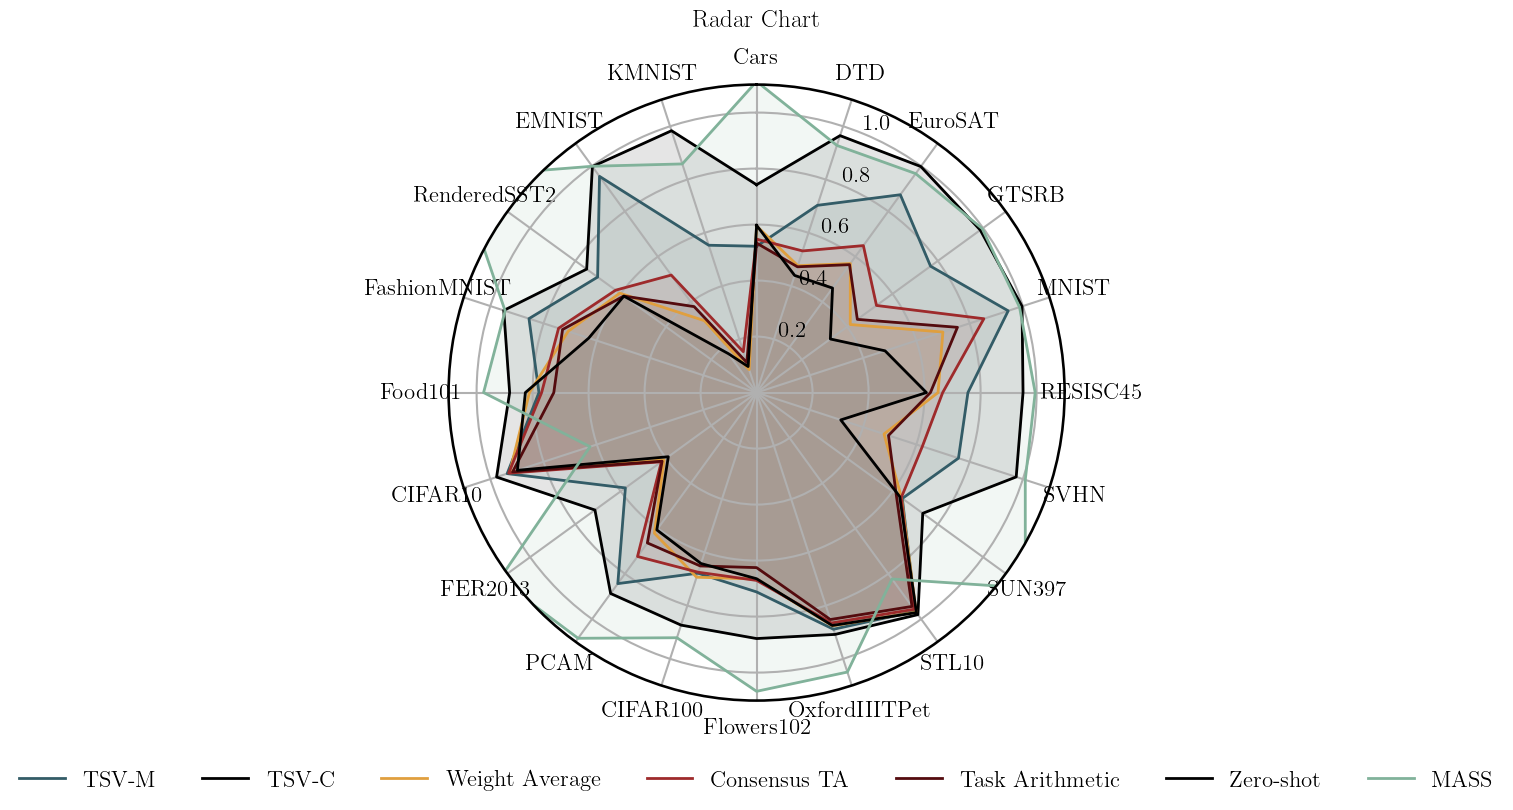

In [28]:

plot_radar_chart(all_results['ViT-B-32']['20 Tasks'], color_map=color_map)

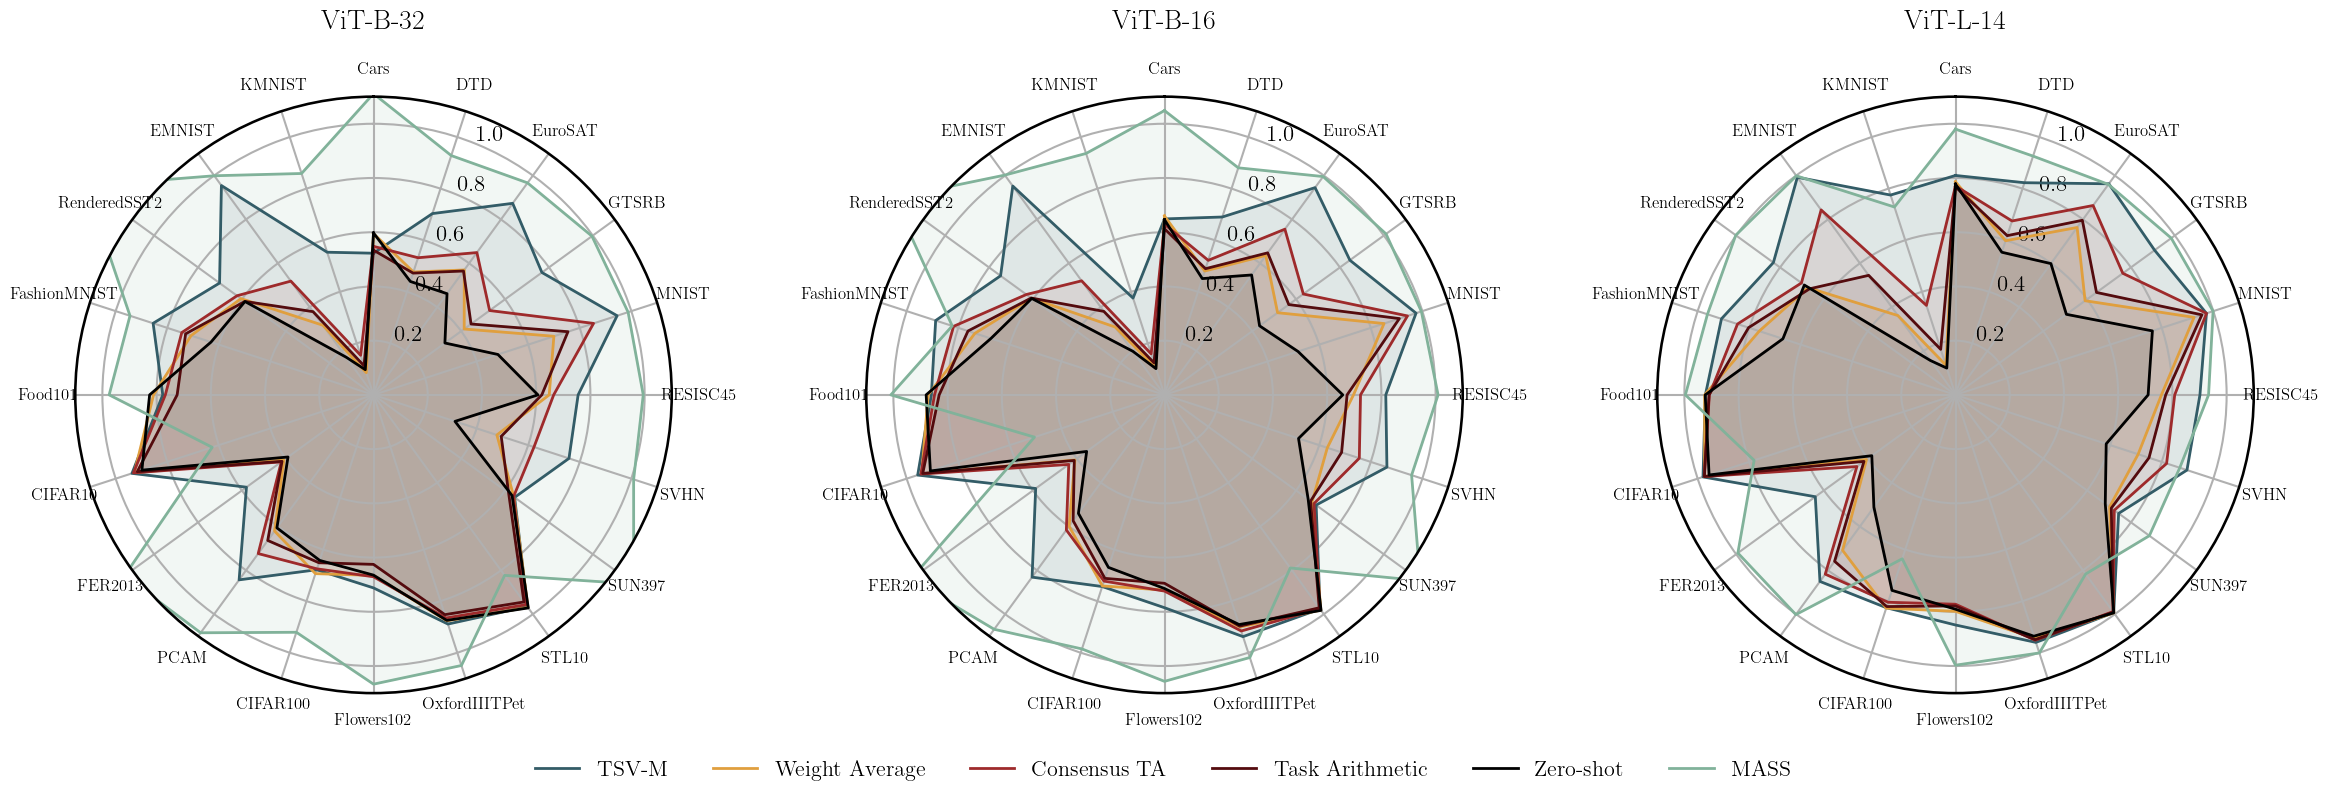

In [29]:
def plot_multi_radar_chart(model_data, color_map, title="Radar Chart"):
    """
    Plot radar charts for multiple models in a single row with a shared legend.

    Parameters:
    -----------
    model_data : dict
        Mapping from model names to their "20 Tasks" data.
        For example:
            {
              'ViT-B-32': { 'MASS': {ds1: acc, ds2: acc, ...}, 'TSV-M': { ... }, ... },
              'ViT-B-16': { ... },
              'ViT-L-14': { ... }
            }
    color_map : dict
        Mapping from method label to color.
    title : str, optional
        Title for the radar chart figure.
    """
    models = list(model_data.keys())
    n_models = len(models)
    
    # Use the first model's first method to set up the categories (assumes all share same keys)
    first_model = models[0]
    first_method = list(model_data[first_model].keys())[0]
    categories = list(model_data[first_model][first_method].keys())
    N = len(categories)
    
    # Compute angles for the radar chart (close the loop)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    # Create a single row of subplots (one per model)
    fig, axs = plt.subplots(nrows=1, ncols=n_models, figsize=(8 * n_models, 8), subplot_kw=dict(polar=True))
    fig.subplots_adjust(wspace=0.3)

    # If only one model, wrap axs in a list for consistency
    if n_models == 1:
        axs = [axs]
    
    for ax, model in zip(axs, models):
        data_dict = model_data[model]
        
        # Setup polar axis: move 0° to top and set clockwise direction
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=12)
        ax.set_ylim(0, 1.1)
        
        # Plot each method's data as a separate line
        for method, task_dict in data_dict.items():

            if method == 'TSV-C':
                continue
            # Extract values in the order of categories, and close the loop
            values = [task_dict[cat] for cat in categories]
            values += values[:1]
            color = color_map.get(method, "black")
            ax.plot(angles, values, color=color, linewidth=2, label=method)
            ax.fill(angles, values, color=color, alpha=0.1)
        
        ax.set_title(model, y=1.1, fontsize=20)
    
    # Create a shared legend for all subplots using handles from the first subplot.
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels),
               bbox_to_anchor=(0.5, 0), fontsize=16, frameon=False)
    
    if title:
        plt.suptitle(title, fontsize=24, y=1.05)
    
    plt.tight_layout(rect=[0.0, 0.1, 1, 0.95])

    plt.savefig("figures/radar_chart_three_models_n20.pdf")
    plt.show()


# Build a dictionary mapping each model to its "20 Tasks" data.
model_data = {
    'ViT-B-32': all_results['ViT-B-32']['20 Tasks'],
    'ViT-B-16': all_results['ViT-B-16']['20 Tasks'],
    'ViT-L-14': all_results['ViT-L-14']['20 Tasks']
}

color_map = {
    'MASS': palette['green'],
    'TSV-M': palette['blue'],
    'Weight Average': palette['yellow'],
    'Consensus TA': palette['red'],
    'Task Arithmetic': palette['dark red'],
    'Zero-Shot': palette['white']
}

plot_multi_radar_chart(model_data, color_map=color_map, title="")
